# Python and SageMaker Setup

In [7]:
# !pip -q install transformers torch
!nvidia-smi

Thu Apr  6 22:04:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   47C    P0    34W /  70W |    819MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [61]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
from sagemaker.predictor import csv_serializer    # Converts strings for HTTP POST requests on inference
from tqdm import tqdm

from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler,random_split
import torch
from tqdm.auto import tqdm
from transformers import AdamW
import matplotlib.pyplot as plt

# Prompt-based Bert: n-Shots Text Classification

In [62]:
def tokenize_multipart_input(
    input_text_list, 
    max_length, 
    tokenizer, 
    template,
    label_word_list, 
    first_sent_limit=None,
    other_sent_limit=None,
    truncate_head=False,
):
    def enc(text):
        return tokenizer.encode(text, add_special_tokens=False)

    input_ids = []
    attention_mask = []
    token_type_ids = [] # Only for BERT
    mask_pos = None # Position of the mask token

    """
    Concatenate all sentences and prompts based on the provided template.
    Template example: '*cls*It was*mask*.*sent_0**<sep>*'
    *xx* represent variables:
        *cls*: cls_token
        *mask*: mask_token
        *sep*: sep_token
        *sep+*: sep_token, also means +1 for segment id
        *sent_i*: sentence i (input_text_list[i])
        *label_i*: label_word_list[i]
        *label_x*: label depends on the example id (support_labels needed). this is only used in GPT-3's in-context learning
    Use "_" to replace space.
    PAY ATTENTION TO SPACE!! DO NOT leave space before variables, for this will lead to extra space token.
    """

    special_token_mapping = {
        'cls': tokenizer.cls_token_id, 'mask': tokenizer.mask_token_id, 'sep': tokenizer.sep_token_id, 'sep+': tokenizer.sep_token_id, 
    }
    template_list = template.split('*') # Get variable list in the template
    segment_id = 0 # Current segment id. Segment id +1 if encountering sep+.

    for part_id, part in enumerate(template_list):
        new_tokens = []
        segment_plus_1_flag = False
        if part in special_token_mapping:
            new_tokens.append(special_token_mapping[part])
            if part == 'sep+':
                segment_plus_1_flag = True
        elif part[:6] == 'label_':
            # Note that label_word_list already has extra space, so do not add more space ahead of it.
            label_id = int(part.split('_')[1])
            label_word = label_word_list[label_id]
            new_tokens.append(label_word)
        elif part[:5] == 'sent_':
            sent_id = int(part.split('_')[1])
            new_tokens += enc(input_text_list[sent_id]) 
        else:
            # Just natural language prompt
            part = part.replace('_', ' ') 
            # handle special case when T5 tokenizer might add an extra space
            if len(part) == 1:
                new_tokens.append(tokenizer._convert_token_to_id(part))
            else:
                new_tokens += enc(part)

        if part[:4] == 'sent' or part[1:5] == 'sent':
            # If this part is the sentence, limit the sentence length
            sent_id = int(part.split('_')[1])
            if sent_id == 0:
                if first_sent_limit is not None:
                    new_tokens = new_tokens[:first_sent_limit]
            else:
                if other_sent_limit is not None:
                    new_tokens = new_tokens[:other_sent_limit]

        input_ids += new_tokens
        attention_mask += [1 for i in range(len(new_tokens))]
        token_type_ids += [segment_id for i in range(len(new_tokens))]

        if segment_plus_1_flag:
            segment_id += 1

    while len(input_ids) < max_length:
        input_ids.append(tokenizer.pad_token_id)
        attention_mask.append(0)
        token_type_ids.append(0)

    # Truncate
    if len(input_ids) > max_length:
        if truncate_head:
            input_ids = input_ids[-max_length:]
            attention_mask = attention_mask[-max_length:]
            token_type_ids = token_type_ids[-max_length:]
        else:
            # Default is to truncate the tail
            input_ids = input_ids[:max_length]
            attention_mask = attention_mask[:max_length]
            token_type_ids = token_type_ids[:max_length]

    # Find mask token
    mask_pos = [input_ids.index(tokenizer.mask_token_id)]

    return {'input_ids': torch.LongTensor(input_ids), 'attention_mask': torch.LongTensor(attention_mask),
              'token_type_ids': torch.LongTensor(token_type_ids), "mask_pos": torch.LongTensor(mask_pos)}


In [63]:
from transformers import DataProcessor, InputExample
import torch
class TextClassificationProcessor(DataProcessor):
    """
    Data processor for text classification datasets (mr, sst-5, subj, trec, cr, mpqa).
    """

    def __init__(self, samples):
        self.n = samples
        pass

    def get_example_from_tensor_dict(self, tensor_dict):
        """See base class."""
        return InputExample(
            tensor_dict["idx"].numpy(),
            tensor_dict["sentence"].numpy().decode("utf-8"),
            None,
            str(tensor_dict["label"].numpy()),
        )
  
    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(pd.read_csv(os.path.join(data_dir, "train{n}.csv".format(n = self.n)), header=None).values.tolist(), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(pd.read_csv(os.path.join(data_dir, "dev{n}.csv".format(n = self.n)), header=None).values.tolist(), "dev")

    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(pd.read_csv(os.path.join(data_dir, "test{n}.csv".format(n = self.n)), header=None).values.tolist(), "test")

    def get_labels(self):
        """See base class."""
        return list(range(5))
        
    def _create_examples(self, lines, set_type):
        """Creates examples for the training, dev and test sets."""
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            examples.append(InputExample(guid=guid, text_a=line[1], label=line[0]))

        return examples

In [64]:
def input_example_to_tuple(example): 
    return [example.text_a]
    
class FewShotDataset(Dataset):

    def __init__(self, samples, data_dir, mapping, template, tokenizer, mode="train"):
        self.data_dir = data_dir
        self.mapping = mapping
        self.max_seq_length = 512
        self.template = template
        self.truncate_head = True
        self.first_sent_limit = 256
        self.other_sent_limit = 256 

        processor = TextClassificationProcessor(samples)
        self.tokenizer = tokenizer

        self.label_list = processor.get_labels()
        num_labels = len(self.label_list)

        self.label_to_word = eval(self.mapping)

        for key in self.label_to_word:
            # For RoBERTa/BART/T5, tokenization also considers space, so we use space+word as label words.
            if self.label_to_word[key][0] not in ['<', '[', '.', ',']:
                # Make sure space+word is in the vocabulary
                self.label_to_word[key] = self.tokenizer._convert_token_to_id(self.tokenizer.tokenize(' ' + self.label_to_word[key])[0])
            else:
                self.label_to_word[key] = self.tokenizer._convert_token_to_id(self.label_to_word[key])

        self.label_word_list = [self.label_to_word[str(label)] for label in self.label_list]

        if mode == "dev":
            self.support_examples = processor.get_dev_examples(data_dir)
        elif mode == "test":
            self.support_examples = processor.get_test_examples(data_dir)
        else:
            self.support_examples = processor.get_train_examples(data_dir)
        
    def __len__(self):
        return len(self.support_examples)
    
    def __getitem__(self, i):
        inputs = tokenize_multipart_input(
            input_text_list=[self.support_examples[i].text_a],
            max_length=self.max_seq_length,
            tokenizer=self.tokenizer,
            template=self.template,
            label_word_list=self.label_word_list,
            first_sent_limit=self.first_sent_limit,
            other_sent_limit=self.other_sent_limit,
            truncate_head=self.truncate_head,
        )

        labels = inputs['input_ids'].clone()
        labels[int(inputs["mask_pos"][0])] = self.label_to_word[str(self.support_examples[i].label)]
        inputs["labels"] = labels
        inputs["labels_idx"] = self.support_examples[i].label
        return inputs


In [65]:
from transformers import BertTokenizer, BertForMaskedLM

## 3000, 1000, 100 

## manually 3 by 3 
## 3 mappings
## 2 templates
## 1 GPT template

## collect loss, F1
## plot loss, F1

## pick the best model on 50,000

#todo
#sample size change from 100, 1000, 3000
#for each sample size, I update mapping 3 times
# for each mapping, I update template three times(two manual, and 1 GPT)
# " " = "_"
sample_size = 100
model_name = 'bert-base-uncased'
data_dir = "data/k-shot/"
mapping = "{'0': 'sad', '1': 'bad', '2': 'ok', '3': 'nice', '4': 'wonderful'}"
# mapping = "{'0': 'terrible', '1': 'bad', '2': 'okay', '3': 'good', '4': 'awesome'}"
# mapping = "{'0': 'worst', '1': 'poor', '2': 'alright', '3': 'good', '4': 'best'}"
template = "*cls**sent_0*_it_was*mask*.*sep+*"
# template = "*cls**sent_0*_the_reviewer_left_a*mask*_review*.*sep+*"
# template = "*cls**sent_0*_given_the_review,_the_reviewer_thought_the_product_to_be*mask*.*sep+*"

tokenizer = BertTokenizer.from_pretrained(model_name)


## k-shot turning

In [66]:
epochs = 2

In [67]:
train_dataset = FewShotDataset(sample_size, data_dir, mapping, template, tokenizer)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True, 
)

val_dataset = FewShotDataset(sample_size, data_dir, mapping, template, tokenizer, mode="dev")
val_dataloader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=True, 
)
print(len(train_dataset))

131


In [68]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [69]:
model = BertForMaskedLM.from_pretrained(model_name, return_dict=True)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [70]:
optimizer = AdamW(model.parameters(), lr=2e-5)

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [71]:
model.train()
losses = []
index = list(train_dataset.label_to_word.values())

best_eval_accuracy = 0 ###
saved_model = "k_shots_" + str(len(train_dataset)) + "_" + model_name

for epoch in range(epochs):
    loop = tqdm(train_dataloader)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        losses.append(float(loss.item()))
        loss.backward()
        optimizer.step()

        loop.set_description("Epoch: {}".format(epoch))
        loop.set_postfix(loss=loss.item())
        
    model.eval()##
    total_dev_accuracy = 0
    
    with torch.no_grad():##
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            output = model(input_ids, attention_mask=attention_mask, labels=None)

            y_pred = torch.softmax(output.logits[:, :, index], dim=-1)
            y_pred = torch.argmax(y_pred, dim=-1)[:, batch["mask_pos"][:, 0]].diagonal().to("cpu").numpy()
            y = batch["labels_idx"].to("cpu").numpy()
        
            f1 = f1_score(y_pred, y, average='weighted')
            acc = accuracy_score(y_pred, y)

            total_dev_accuracy += acc 
        avg_dev_accuracy = total_dev_accuracy / len(val_dataloader)
        if avg_dev_accuracy > total_dev_accuracy:
            total_dev_accuracy = avg_dev_accuracy
            torch.save(model, './models/'+ saved_model) 

print(losses)      

# x = range(1,len(losses)+1)
# plt.title('The loss versus number of steps')
# plt.plot(x, losses, label = 'Losses')
# plt.xlabel('Steps')
# plt.ylabel('Losses')
# plt.show()

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

[15.479159355163574, 13.306514739990234, 12.472718238830566, 11.95870590209961, 9.569679260253906, 9.051413536071777, 9.103031158447266, 7.773815155029297, 8.17183780670166, 6.829180717468262, 6.718824863433838, 6.599327564239502, 5.854565143585205, 5.672745704650879, 5.736605644226074, 5.24533224105835, 4.53653621673584, 4.708620071411133, 4.248814105987549, 3.951430320739746, 3.96201229095459, 3.615417242050171, 3.2086315155029297, 3.0452871322631836, 2.6200969219207764, 2.7911088466644287, 2.491680860519409, 2.212869882583618, 2.263265609741211, 2.1121814250946045, 1.8813679218292236, 1.721512794494629, 1.615320086479187, 1.4978302717208862]


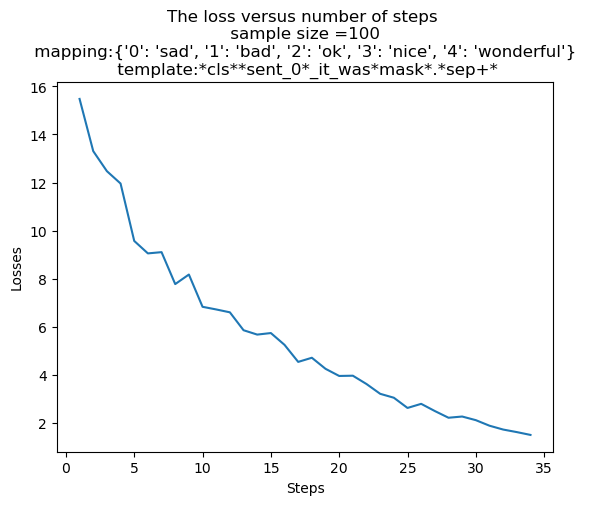

In [72]:
x = range(1,len(losses)+1)
plt.title('The loss versus number of steps \n sample size ='+str(sample_size)+' \n mapping:'+str(mapping)+' \n template:'+str(template))
plt.plot(x, losses, label = 'Losses')
plt.xlabel('Steps')
plt.ylabel('Losses')
plt.show()

In [73]:
test_dataset = FewShotDataset(sample_size, data_dir, mapping, template, tokenizer, mode="test")
test_dataloader = DataLoader(
    test_dataset,
    sampler = SequentialSampler(test_dataset),
    batch_size= 32,
)

index = list(test_dataset.label_to_word.values())

model = torch.load('./models/' + saved_model)
model.eval()

total_test_accuracy = 0
total_test_f1 = 0

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        output = model(input_ids, attention_mask=attention_mask, labels=None)

        y_pred = torch.softmax(output.logits[:, :, index], dim=-1)
        y_pred = torch.argmax(y_pred, dim=-1)[:, batch["mask_pos"][:, 0]].diagonal().to("cpu").numpy()
        y = batch["labels_idx"].to("cpu").numpy()
        
        f1 = f1_score(y_pred, y, average='weighted')
        acc = accuracy_score(y_pred, y)

        total_test_accuracy += acc 
        total_test_f1 += f1

avg_test_accuracy = total_test_accuracy / len(test_dataloader)
print("Accuracy: {0:.4f}".format(avg_test_accuracy))   

avg_test_f1 = total_test_f1 / len(test_dataloader)
print("F1: {0:.4f}".format(avg_test_f1))   



  0%|          | 0/149 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (600 > 512). Running this sequence through the model will result in indexing errors


Accuracy: 0.6415
F1: 0.7767


In [74]:
# Accuracy: 0.6347
# F1: 0.7659

# Accuracy: 0.6407
# F1: 0.7737

# base bert + 0.04
# last template +0.003 
# this +0.001